In [898]:
from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mutual_info_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_curve, auc, roc_auc_score
from collections import Counter

import random

Data Preparation

In [899]:
churn_df = pd.read_csv('../dataset/telco_customer_churn.csv')

In [900]:
churn_df.columns = churn_df.columns.str.lower().str.strip().str.replace(' ', '_')

In [901]:
churn_df.totalcharges = pd.to_numeric(churn_df['totalcharges'], errors='coerce')

churn_df.totalcharges = churn_df.totalcharges.fillna(0)

In [902]:
churn_df.churn = (churn_df.churn == 'Yes').astype(int)

Setting up The Validation Framework

In [903]:
df_full_train, df_test = train_test_split(churn_df, test_size=0.2, random_state=1)

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [904]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

In [905]:
print(f'df_train length: {len(df_train)}, y_train length: {len(y_train)}')
      
print(f'df_val length: {len(df_val)}, y_val lenght: {len(y_val)}')

print(f'df_test length: {len(df_test)}, y_test lenght: {len(y_test)}')

df_train length: 4225, y_train length: 4225
df_val length: 1409, y_val lenght: 1409
df_test length: 1409, y_test lenght: 1409


In [906]:
del df_train['churn']
del df_val['churn']
del df_test['churn']

EDA

In [907]:
df_full_train.churn.value_counts(normalize=True).round(2)

churn
0    0.73
1    0.27
Name: proportion, dtype: float64

In [908]:
numerical_cols = ['tenure', 'monthlycharges', 'totalcharges']

categorical_cols = [
    'gender', 'seniorcitizen', 'partner', 'dependents',
    'phoneservice', 'multiplelines', 'internetservice',
    'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
    'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
    'paymentmethod'
]

In [909]:
full_churn_rate = df_full_train.churn.mean()

Feature Importance

In [910]:
df_full_train[df_full_train.partner == 'Yes'].churn.mean() / full_churn_rate

0.7594724924338315

In [911]:
df_full_train[df_full_train.partner == 'No'].churn.mean() / full_churn_rate

1.2216593879412643

In [912]:
for c in categorical_cols:
    print(c)
    df_group = df_full_train.groupby(c)['churn'].agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - full_churn_rate
    df_group['risk'] = df_group['mean'] / full_churn_rate
    display(df_group)
    print()

gender


,mean,count,diff,risk
gender,,,,
Female,0.276824,2796,0.006856,1.025396
Male,0.263214,2838,-0.006755,0.974980



seniorcitizen


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208



partner


,mean,count,diff,risk
partner,,,,
No,0.329809,2932,0.059841,1.221659
Yes,0.205033,2702,-0.064935,0.759472



dependents


,mean,count,diff,risk
dependents,,,,
No,0.313760,3968,0.043792,1.162212
Yes,0.165666,1666,-0.104302,0.613651



phoneservice


,mean,count,diff,risk
phoneservice,,,,
No,0.241316,547,-0.028652,0.893870
Yes,0.273049,5087,0.003081,1.011412



multiplelines


,mean,count,diff,risk
multiplelines,,,,
No,0.257407,2700,-0.012561,0.953474
No phone service,0.241316,547,-0.028652,0.893870
Yes,0.290742,2387,0.020773,1.076948



internetservice


,mean,count,diff,risk
internetservice,,,,
DSL,0.192347,1934,-0.077621,0.712482
Fiber optic,0.425171,2479,0.155203,1.574895
No,0.077805,1221,-0.192163,0.288201



onlinesecurity


,mean,count,diff,risk
onlinesecurity,,,,
No,0.420921,2801,0.150953,1.559152
No internet service,0.077805,1221,-0.192163,0.288201
Yes,0.153226,1612,-0.116742,0.567570



onlinebackup


,mean,count,diff,risk
onlinebackup,,,,
No,0.404323,2498,0.134355,1.497672
No internet service,0.077805,1221,-0.192163,0.288201
Yes,0.217232,1915,-0.052736,0.804660



deviceprotection


,mean,count,diff,risk
deviceprotection,,,,
No,0.395875,2473,0.125907,1.466379
No internet service,0.077805,1221,-0.192163,0.288201
Yes,0.230412,1940,-0.039556,0.853480



techsupport


,mean,count,diff,risk
techsupport,,,,
No,0.418914,2781,0.148946,1.551717
No internet service,0.077805,1221,-0.192163,0.288201
Yes,0.159926,1632,-0.110042,0.592390



streamingtv


,mean,count,diff,risk
streamingtv,,,,
No,0.342832,2246,0.072864,1.269897
No internet service,0.077805,1221,-0.192163,0.288201
Yes,0.302723,2167,0.032755,1.121328



streamingmovies


,mean,count,diff,risk
streamingmovies,,,,
No,0.338906,2213,0.068938,1.255358
No internet service,0.077805,1221,-0.192163,0.288201
Yes,0.307273,2200,0.037305,1.138182



contract


,mean,count,diff,risk
contract,,,,
Month-to-month,0.431701,3104,0.161733,1.599082
One year,0.120573,1186,-0.149395,0.446621
Two year,0.028274,1344,-0.241694,0.104730



paperlessbilling


,mean,count,diff,risk
paperlessbilling,,,,
No,0.172071,2313,-0.097897,0.637375
Yes,0.338151,3321,0.068183,1.252560



paymentmethod


,mean,count,diff,risk
paymentmethod,,,,
Bank transfer (automatic),0.168171,1219,-0.101797,0.622928
Credit card (automatic),0.164339,1217,-0.105630,0.608733
Electronic check,0.455890,1893,0.185922,1.688682
Mailed check,0.193870,1305,-0.076098,0.718121


Feature Importance

In [913]:
mutual_info_score(df_full_train.churn, df_full_train.contract)

0.0983203874041556

In [914]:
mutual_info_score(df_full_train.churn, df_full_train.gender)

0.0001174846211139946

In [915]:
mutual_info_score(df_full_train.churn, df_full_train.partner)

0.009967689095399745

In [916]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)

In [917]:
mi = df_full_train[categorical_cols].apply(mutual_info_churn_score)

mi.sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

Feature Importance: Correlation

In [918]:
df_full_train[numerical_cols].corrwith(df_full_train.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

In [919]:
df_full_train.loc[df_full_train['tenure'] <= 2, 'churn'].mean()

0.5953420669577875

In [920]:
df_full_train.loc[(df_full_train['tenure'] > 2) &(df_full_train['tenure'] <= 12), 'churn'].mean()

0.3994413407821229

In [921]:
df_full_train.loc[df_full_train['tenure'] > 12, 'churn'].mean()

0.17634908339788277

In [922]:
df_full_train.loc[df_full_train['monthlycharges'] <= 20, 'churn'].mean()

0.08795411089866156

In [923]:
df_full_train.loc[(df_full_train['monthlycharges'] > 20) & (df_full_train['monthlycharges'] <= 50), 'churn'].mean()

0.18340943683409436

In [924]:
df_full_train.loc[df_full_train['monthlycharges'] > 50, 'churn'].mean()

0.32499341585462205

In [925]:
x_train = pd.get_dummies(df_train[categorical_cols + numerical_cols], dtype='int')

x_val = pd.get_dummies(df_val[categorical_cols + numerical_cols], dtype='int')

x_test = pd.get_dummies(df_test[categorical_cols + numerical_cols], dtype='int')

Logistic Regression

In [926]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [927]:
z = np.linspace(-5, 5, 51)
z

array([-5. , -4.8, -4.6, -4.4, -4.2, -4. , -3.8, -3.6, -3.4, -3.2, -3. ,
       -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8,
       -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,
        1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,
        3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ])

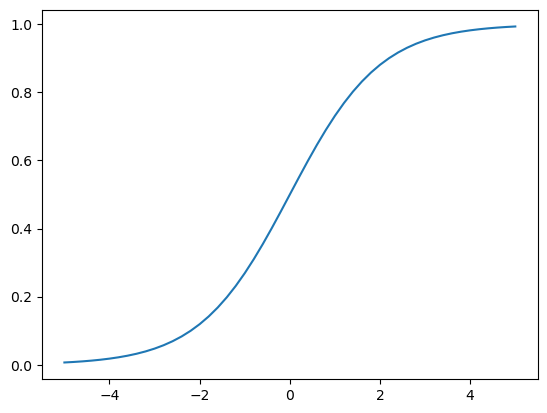

In [928]:
plt.plot(z, sigmoid(z))

In [929]:
def linear_regression(xi, w0, w):

    result = w0

    for j in range(len(w)):
        result = result + xi[j] * w[j]
    
    return result

In [930]:
def logistic_regression(xi, w0, w):

    return sigmoid(linear_regression(xi, w0, w))

Train Linear Regression

In [931]:
from sklearn.linear_model import LogisticRegression

In [932]:
model = LogisticRegression()

model.fit(x_train, y_train)

c:\Users\paula\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [933]:
model.coef_[0]

array([ 2.15224199e-01, -7.03616169e-02,  3.68167175e-03,  3.81927605e-04,
       -3.43028956e-02, -7.33320806e-02, -1.65879128e-01,  5.82441522e-02,
       -2.96872437e-02, -7.79477325e-02,  1.41269482e-01, -2.48904459e-01,
       -2.57956969e-01,  1.41269482e-01,  9.05250992e-03, -3.34782576e-01,
        3.16141629e-01, -8.89940288e-02,  2.65318511e-01, -8.89940288e-02,
       -2.83959458e-01,  6.24999231e-02, -8.89940288e-02, -8.11408704e-02,
        6.26584578e-02, -8.89940288e-02, -8.12994052e-02,  2.13189670e-01,
       -8.89940288e-02, -2.31830617e-01, -7.07660269e-02, -8.89940288e-02,
        5.21250796e-02, -1.20173144e-01, -8.89940288e-02,  1.01532196e-01,
        4.74076114e-01, -1.74673569e-01, -4.07037522e-01, -2.31045707e-01,
        1.23410731e-01, -8.69112458e-02, -3.20327748e-02,  7.04570316e-02,
       -5.91479873e-02])

In [934]:
model.coef_[0].round(3)

array([ 0.215, -0.07 ,  0.004,  0.   , -0.034, -0.073, -0.166,  0.058,
       -0.03 , -0.078,  0.141, -0.249, -0.258,  0.141,  0.009, -0.335,
        0.316, -0.089,  0.265, -0.089, -0.284,  0.062, -0.089, -0.081,
        0.063, -0.089, -0.081,  0.213, -0.089, -0.232, -0.071, -0.089,
        0.052, -0.12 , -0.089,  0.102,  0.474, -0.175, -0.407, -0.231,
        0.123, -0.087, -0.032,  0.07 , -0.059])

In [935]:
model.predict(x_train)

array([0, 1, 1, ..., 1, 0, 1])

In [936]:
y_pred = model.predict_proba(x_val)[:, 1]

In [937]:
churn_decision = (y_pred >= 0.5)

In [938]:
(churn_decision.astype(int) == y_val).mean()

0.8034066713981547

In [939]:
df_pred = pd.DataFrame()

df_pred['probability'] = y_pred

df_pred['prediction'] = churn_decision.astype(int)

df_pred['actual'] = y_val

df_pred['correct'] = df_pred.prediction == df_pred.actual

In [940]:
df_pred

,probability,prediction,actual,correct
0,0.009027,0,0,True
1,0.204545,0,0,True
2,0.212237,0,0,True
3,0.543149,1,1,True
4,0.213820,0,0,True
...,...,...,...,...
1404,0.313663,0,0,True
1405,0.039441,0,1,False
1406,0.136585,0,0,True
1407,0.799662,1,1,True


In [941]:
df_pred['correct'].value_counts()

correct
True     1132
False     277
Name: count, dtype: int64

Model Interpretation

In [942]:
dict(zip(x_train.columns, model.coef_[0].round(3)))

{'seniorcitizen': 0.215,
 'tenure': -0.07,
 'monthlycharges': 0.004,
 'totalcharges': 0.0,
 'gender_Female': -0.034,
 'gender_Male': -0.073,
 'partner_No': -0.166,
 'partner_Yes': 0.058,
 'dependents_No': -0.03,
 'dependents_Yes': -0.078,
 'phoneservice_No': 0.141,
 'phoneservice_Yes': -0.249,
 'multiplelines_No': -0.258,
 'multiplelines_No phone service': 0.141,
 'multiplelines_Yes': 0.009,
 'internetservice_DSL': -0.335,
 'internetservice_Fiber optic': 0.316,
 'internetservice_No': -0.089,
 'onlinesecurity_No': 0.265,
 'onlinesecurity_No internet service': -0.089,
 'onlinesecurity_Yes': -0.284,
 'onlinebackup_No': 0.062,
 'onlinebackup_No internet service': -0.089,
 'onlinebackup_Yes': -0.081,
 'deviceprotection_No': 0.063,
 'deviceprotection_No internet service': -0.089,
 'deviceprotection_Yes': -0.081,
 'techsupport_No': 0.213,
 'techsupport_No internet service': -0.089,
 'techsupport_Yes': -0.232,
 'streamingtv_No': -0.071,
 'streamingtv_No internet service': -0.089,
 'streamingtv

In [943]:
small = ['contract', 'tenure', 'monthlycharges']

df_train_small = df_train[small]
df_val_small = df_val[small]

In [944]:
X_train_small = pd.get_dummies(df_train_small)

X_val_small = pd.get_dummies(df_val_small)

In [945]:
model_small = LogisticRegression()

model_small.fit(X_train_small, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [946]:
w0 = model_small.intercept_[0]
w0.round(3)

-2.478

In [947]:
w = model_small.coef_[0]
w

array([-0.03619005,  0.02748534,  0.9711394 , -0.02379507, -0.94828863])

In [948]:
dict(zip(X_train_small.columns, w.round(3)))

{'tenure': -0.036,
 'monthlycharges': 0.027,
 'contract_Month-to-month': 0.971,
 'contract_One year': -0.024,
 'contract_Two year': -0.948}

In [949]:
sigmoid(-2.478 + -0.036 * 2 + 0.027 * 50 + 0.971)

0.4429988821891786

Using the Model

In [950]:
X_full_train = pd.get_dummies(df_full_train[categorical_cols + numerical_cols])

y_full_train = df_full_train['churn']

In [951]:
model = LogisticRegression(max_iter=5000).fit(X_full_train, y_full_train)

In [952]:
X_test = pd.get_dummies(df_test[categorical_cols + numerical_cols])

In [953]:
y_pred = model.predict_proba(x_test)[:, 1]

In [954]:
df_pred = pd.DataFrame()

df_pred['proba'] = y_pred
df_pred['prediction'] = (y_pred >= 0.5).astype(int)
df_pred['actual'] = y_test
df_pred['correct'] = df_pred['prediction'] == df_pred['actual']

In [955]:
df_pred

,proba,prediction,actual,correct
0,0.067540,0,0,True
1,0.095626,0,0,True
2,0.334825,0,0,True
3,0.457903,0,1,False
4,0.217229,0,0,True
...,...,...,...,...
1404,0.524542,1,1,True
1405,0.029789,0,0,True
1406,0.005174,0,0,True
1407,0.203248,0,0,True


In [956]:
df_pred.correct.mean()

0.8119233498935415

In [957]:
customer = pd.get_dummies(X_test).iloc[[10], :]

int(model.predict_proba(customer)[:, 1] > 0.5)

C:\Users\paula\AppData\Local\Temp\ipykernel_2120\2067267721.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(model.predict_proba(customer)[:, 1] > 0.5)


0

In [958]:
y_test[10]

0

Accuracy and Dummy Model

In [959]:
model.fit(x_train, y_train)

y_pred = model.predict_proba(x_val)[:, 1]

In [960]:
churn_decision = (y_pred >= 0.5).astype(int)

In [961]:
(y_val == churn_decision).mean()

0.8034066713981547

In [962]:
(y_val == churn_decision).sum() / len(y_val)

0.8034066713981547

In [963]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:

    churn_decision = (y_pred >= t).astype(int)

    score = accuracy_score(y_val, churn_decision)

    scores.append(score)

    print('%.2f, %.3f' % (t, score))

0.00, 0.274
0.05, 0.513
0.10, 0.608
0.15, 0.661
0.20, 0.703
0.25, 0.734
0.30, 0.759
0.35, 0.765
0.40, 0.782
0.45, 0.791
0.50, 0.803
0.55, 0.802
0.60, 0.796
0.65, 0.789
0.70, 0.766
0.75, 0.742
0.80, 0.729
0.85, 0.726
0.90, 0.726
0.95, 0.726
1.00, 0.726


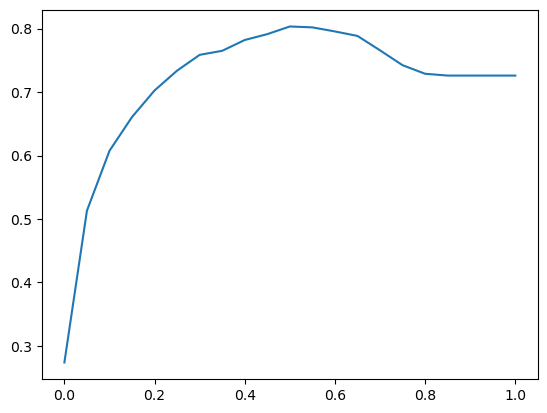

In [964]:
plt.plot(thresholds, scores)

In [965]:
t_scores = dict(zip(thresholds, scores))

best_t = max(t_scores, key=t_scores.get)

best_score = t_scores[best_t]

print(f'best t: {best_t}, score: {best_score}')

best t: 0.5, score: 0.8034066713981547


In [966]:
churn_decision = (y_pred >= 0.5).astype(int)

Counter(churn_decision)

Counter({0: 1094, 1: 315})

In [967]:
Counter(y_val)

Counter({0: 1023, 1: 386})

Confusion Table

In [968]:
confusion_matrix(y_val, churn_decision)

array([[920, 103],
       [174, 212]], dtype=int64)

In [969]:
prfs = precision_recall_fscore_support(y_val, churn_decision)

In [970]:
p = prfs[0][1]

r = prfs[1][1]

f = prfs[2][1]

s = prfs[3][1]

In [971]:
thresholds = np.linspace(0, 1, 101)

scores = []

for t in thresholds:

    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predicted_positive = (y_pred >= t)
    predicted_negative = (y_pred < t)

    tp = (actual_positive & predicted_positive).sum()
    tn = (actual_negative & predicted_negative).sum()

    fp = (predicted_positive & actual_negative).sum()
    fn = (predicted_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))


In [972]:
conf_columns = ['threshold', 'true_positive', 'false_positive', 'false_negative', 'true_negative']

confusion_matrix_df = pd.DataFrame(scores, columns=conf_columns)

In [973]:
confusion_matrix_df['tpr'] = confusion_matrix_df.true_positive / (confusion_matrix_df.true_positive + confusion_matrix_df.false_negative)
confusion_matrix_df['fpr'] = confusion_matrix_df.false_positive / (confusion_matrix_df.true_negative + confusion_matrix_df.false_positive)

In [974]:
confusion_matrix_df[::10]

,threshold,true_positive,false_positive,false_negative,true_negative,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,533,20,490,0.948187,0.521017
20,0.2,339,372,47,651,0.878238,0.363636
30,0.3,292,246,94,777,0.756477,0.240469
40,0.4,254,175,132,848,0.658031,0.171065
50,0.5,212,103,174,920,0.549223,0.100684
60,0.6,151,53,235,970,0.391192,0.051808
70,0.7,69,13,317,1010,0.178756,0.012708
80,0.8,4,0,382,1023,0.010363,0.000000
90,0.9,0,0,386,1023,0.000000,0.000000


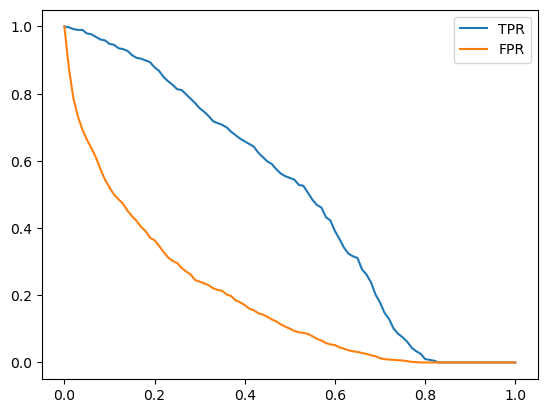

In [975]:
plt.plot(confusion_matrix_df['threshold'], confusion_matrix_df['tpr'], label='TPR')
plt.plot(confusion_matrix_df['threshold'], confusion_matrix_df['fpr'], label='FPR')

plt.legend()

Random Model

In [976]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, len(y_val))

In [977]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [978]:
def tpr_fpr_dataframe(y_val, y_pred):

    thresholds = np.linspace(0, 1, 101)

    scores = []

    for t in thresholds:

        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predicted_positive = (y_pred >= t)
        predicted_negative = (y_pred < t)

        tp = (actual_positive & predicted_positive).sum()
        tn = (actual_negative & predicted_negative).sum()

        fp = (predicted_positive & actual_negative).sum()
        fn = (predicted_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'true_positive', 'false_positive', 'false_negative', 'true_negative']

    df = pd.DataFrame(scores, columns=columns)

    df['tpr'] = df.true_positive / (df.true_positive + df.false_negative)
    df['fpr'] = df.false_positive / (df.true_negative + df.false_positive)

    return df
    

In [979]:
rand_conf_df = tpr_fpr_dataframe(y_val, y_rand)

In [980]:
rand_conf_df[::10]

,threshold,true_positive,false_positive,false_negative,true_negative,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


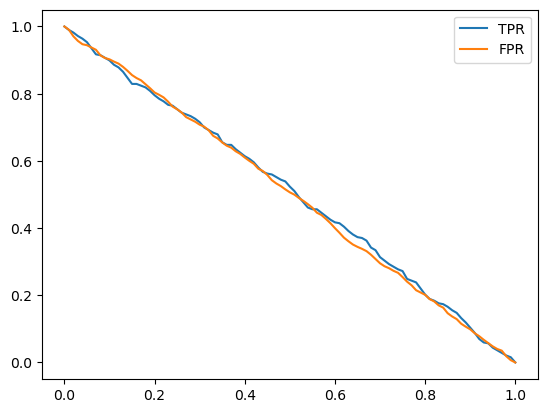

In [981]:
plt.plot(rand_conf_df['threshold'], rand_conf_df['tpr'], label='TPR')
plt.plot(rand_conf_df['threshold'], rand_conf_df['fpr'], label='FPR')

plt.legend()

Ideal Model

In [982]:
1 - y_val.mean()

0.7260468417317246

In [983]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

y_ideal = np.repeat([0, 1], [num_neg, num_pos])

y_ideal_pred = np.linspace(0, 1, len(y_val))

((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [984]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

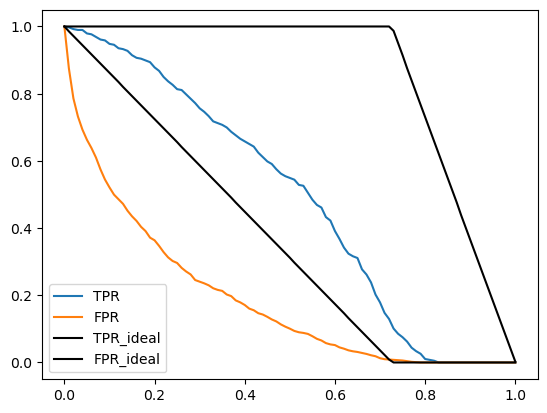

In [985]:
plt.plot(confusion_matrix_df['threshold'], confusion_matrix_df['tpr'], label='TPR')
plt.plot(confusion_matrix_df['threshold'], confusion_matrix_df['fpr'], label='FPR')

# plt.plot(rand_conf_df['threshold'], rand_conf_df['tpr'], label='TPR_rand')
# plt.plot(rand_conf_df['threshold'], rand_conf_df['fpr'], label='FPR_rand')

plt.plot(df_ideal['threshold'], df_ideal['tpr'], label='TPR_ideal', color='black')
plt.plot(df_ideal['threshold'], df_ideal['fpr'], label='FPR_ideal', color='black')

plt.legend()

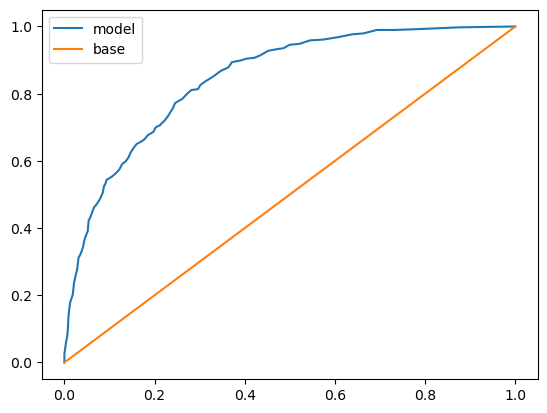

In [986]:
plt.plot(confusion_matrix_df.fpr, confusion_matrix_df.tpr, label='model')
plt.plot([0,1], [0,1], label='base')
plt.legend()


In [987]:
fpr, tpr, thresh = roc_curve(y_val, y_pred)

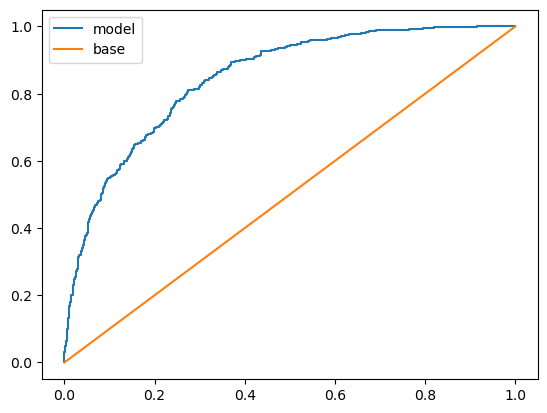

In [988]:
plt.plot(fpr, tpr, label='model')
plt.plot([0,1], [0,1], label='base')
plt.legend()

ROC AUC

In [989]:
auc(fpr, tpr)

0.8463272200527758

In [990]:
auc(confusion_matrix_df.fpr, confusion_matrix_df.tpr)

0.8460739772790584

In [991]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [992]:
roc_auc_score(y_val, y_pred)

0.8463272200527758

In [993]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [994]:
n = 100000
success = 0

random.seed(1)

for i in range(n):

    pos_ind = random.randint(0, len(pos) - 1)

    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n


0.84504

In [995]:
n = 10000

np.random.seed(1)

pos_ind = np.random.randint(0, len(pos), size=n)

neg_ind = np.random.randint(0, len(neg), size=n)

In [996]:
(pos[pos_ind] > neg[neg_ind]).mean()

0.8461

Cross-Validation

In [997]:
def train(df, y_train, C=1):

    X_train = pd.get_dummies(df[numerical_cols + categorical_cols])

    model = LogisticRegression(C=C, max_iter=1000)

    model.fit(X_train, y_train)

    return model

In [998]:
model = train(df_train, y_train)

c:\Users\paula\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [999]:
def predict(df, model):

    y_pred = model.predict_proba(pd.get_dummies(df[numerical_cols + categorical_cols]))[:, 1]

    return y_pred

In [1000]:
y_pred = predict(df_val, model)

In [1001]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [1002]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):

    df_train = df_full_train.iloc[train_idx]

    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.churn.values

    y_val = df_val.churn.values

    del df_train['churn']

    del df_val['churn']

    model = train(df_train, y_train)

    y_pred = predict(df_val, model)

    scores.append(roc_auc_score(y_val, y_pred))

c:\Users\paula\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\paula\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please als

In [1003]:
print("%.3f, %.3f" % (np.mean(scores), np.std(scores)))

0.843, 0.012


In [1004]:
y_full_train = df_full_train['churn']

del df_full_train['churn']

In [1006]:
model = train(df_full_train, y_full_train)

y_pred = predict(df_test, model)

c:\Users\paula\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [1007]:
auc = roc_auc_score(y_test, y_pred)

auc

0.858357166845418